# 주가 예측 LSTM

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/1920px-Recurrent_neural_network_unfold.svg.png)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

Using TensorFlow backend.


# 데이터 읽어들이기

주가 데이터는 다음의 사이트에 가서 다운로드를 받습니다.

https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/005930.KS.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,40.588501,10588400.0
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,39.641438,12647050.0
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,40.588501,11357700.0
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,40.561447,10887800.0
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.182617,8009300.0


# 데이터 전처리

널 데이터 없애기

In [0]:
data.isna().any()

Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
dtype: bool

In [0]:
data.isnull().sum()

Date          0
Open         11
High         11
Low          11
Close        11
Adj Close    11
Volume       11
dtype: int64

In [0]:
data[data["Open"].isnull() == True].head(11)

,Date,Open,High,Low,Close,Adj Close,Volume
995,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN
1000,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN
1024,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1237,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN
1413,2019-08-02,NaN,NaN,NaN,NaN,NaN,NaN
1434,2019-09-03,NaN,NaN,NaN,NaN,NaN,NaN
1439,2019-09-10,NaN,NaN,NaN,NaN,NaN,NaN
1454,2019-10-04,NaN,NaN,NaN,NaN,NaN,NaN
1479,2019-11-11,NaN,NaN,NaN,NaN,NaN,NaN
1482,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
data.dropna(inplace=True)

In [0]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [0]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,40.588501,10588400.0
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,39.641438,12647050.0
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,40.588501,11357700.0
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,40.561447,10887800.0
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.182617,8009300.0


# 차트 확인

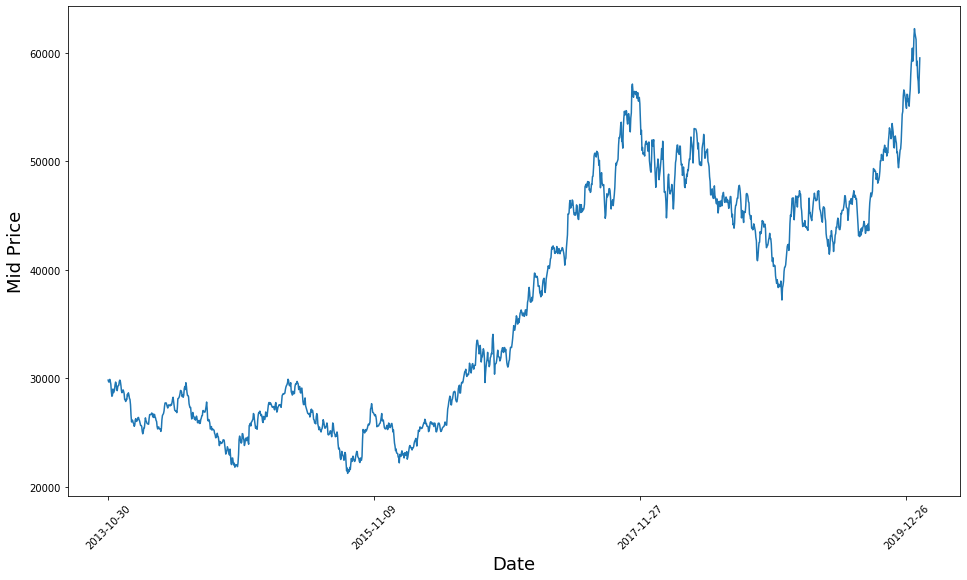

In [0]:
plt.figure(figsize = (16,9))
plt.plot(range(data.shape[0]),(data['Low']+data['High'])/2.0)
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# Open 데이터만 사용


In [0]:
data = data['Open'].values
data = data.reshape(-1, 1)
print(data.shape)
data[:5]

(1526, 1)


array([[29700.],
       [29960.],
       [29800.],
       [29840.],
       [30040.]])

In [0]:
dataset_train = np.array(data[:int(data.shape[0]*0.8)])
dataset_test = np.array(data[int(data.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

(1220, 1)
(356, 1)


# 데이터 전처리

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:5]

array([[0.23076923],
       [0.23796348],
       [0.23353625],
       [0.23464305],
       [0.24017709]])

In [0]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:5]

array([[0.7094632 ],
       [0.68594355],
       [0.65273935],
       [0.64997233],
       [0.62091865]])

# 계산 구간 설정하기

In [0]:
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [0]:
x_train, y_train = create_dataset(dataset_train)
x_train[:1]

array([[0.23076923, 0.23796348, 0.23353625, 0.23464305, 0.24017709,
        0.23796348, 0.21195351, 0.18981738, 0.19756502, 0.20586608,
        0.20863309, 0.21416713, 0.20254566, 0.22246818, 0.22966242,
        0.22412839, 0.22357499, 0.20641948, 0.21195351, 0.21582734,
        0.22080797, 0.22800221, 0.23851688, 0.23907028, 0.21914776,
        0.21140011, 0.20199225, 0.21361372, 0.20586608, 0.20641948,
        0.19811843, 0.18151633, 0.18926397, 0.17874931, 0.1931378 ,
        0.18649696, 0.1936912 , 0.19092418, 0.20420587, 0.20033204,
        0.18815717, 0.18926397, 0.18151633, 0.15495296, 0.1283896 ,
        0.13004981, 0.1283896 , 0.1283896 , 0.13226342, 0.11455451]])

In [0]:
x_test, y_test = create_dataset(dataset_test)
x_test[:1]

array([[0.7094632 , 0.68594355, 0.65273935, 0.64997233, 0.62091865,
        0.62783619, 0.6126176 , 0.61815163, 0.65827338, 0.68594355,
        0.67902601, 0.68456004, 0.70392916, 0.70254566, 0.70807969,
        0.71223022, 0.7426674 , 0.72468179, 0.71776425, 0.68732706,
        0.64028777, 0.66657443, 0.66934145, 0.65135584, 0.64167128,
        0.65412286, 0.66934145, 0.65273935, 0.68179303, 0.70531267,
        0.69701162, 0.70807969, 0.71638074, 0.6942446 , 0.6942446 ,
        0.65827338, 0.64858882, 0.63198672, 0.6610404 , 0.62645268,
        0.60431655, 0.62783619, 0.61815163, 0.63060321, 0.62506918,
        0.62368567, 0.61123409, 0.60708356, 0.60016602, 0.5323741 ]])

In [0]:
# LSTM에 사용하기 위해서 채널 추가하기
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [0]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 96)            37632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 96)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 96)            74112     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 96)            0         
_

In [0]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [0]:
model.fit(x_train, y_train, epochs=50, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





1170/1170 [==============================] - 13s 11ms/step - loss: 0.0322
Epoch 2/50
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0038
Epoch 3/50
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0036
Epoch 4/50
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0031
Epoch 5/50
1170/1170 [==============================] - 11s 10ms/step - loss: 0.0031
Epoch 6/50
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0028
Epoch 7/50
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0035
Epoch 8/50
1170/1170 [==============================] - 11s 10ms/step - loss: 0.0029
Epoch 9/50
1170/1170 [==============================] - 11s 9ms/step - loss: 0.0030
Epoch 10/50
1170/1170 [==============================] - 10s 9ms/step - loss: 0.0027
Epoch 11/50
1170/1170 [==============================]

In [0]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

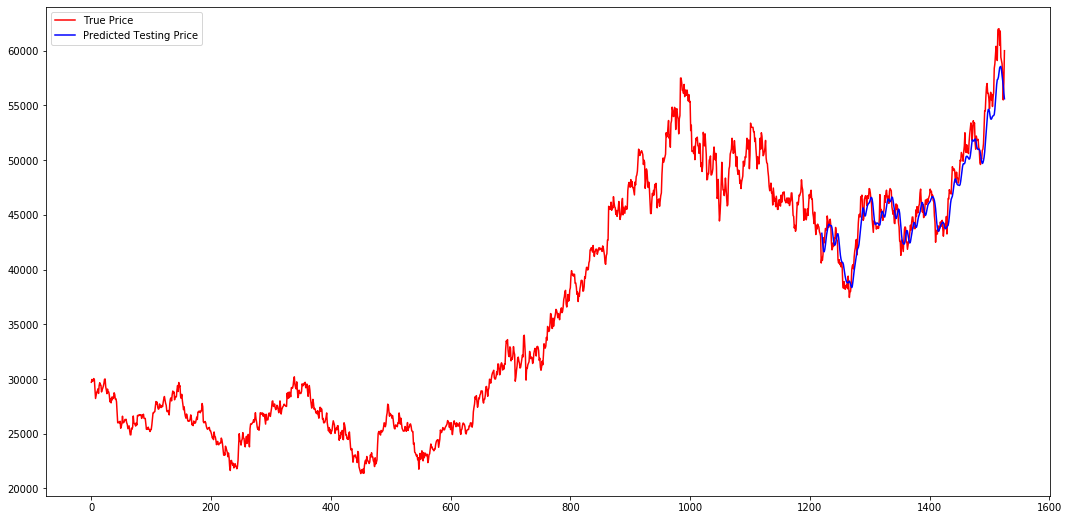

In [0]:
fig, ax = plt.subplots(figsize=(18,9))
plt.plot(data, color='red',  label="True Price")
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Testing Price')
plt.legend()

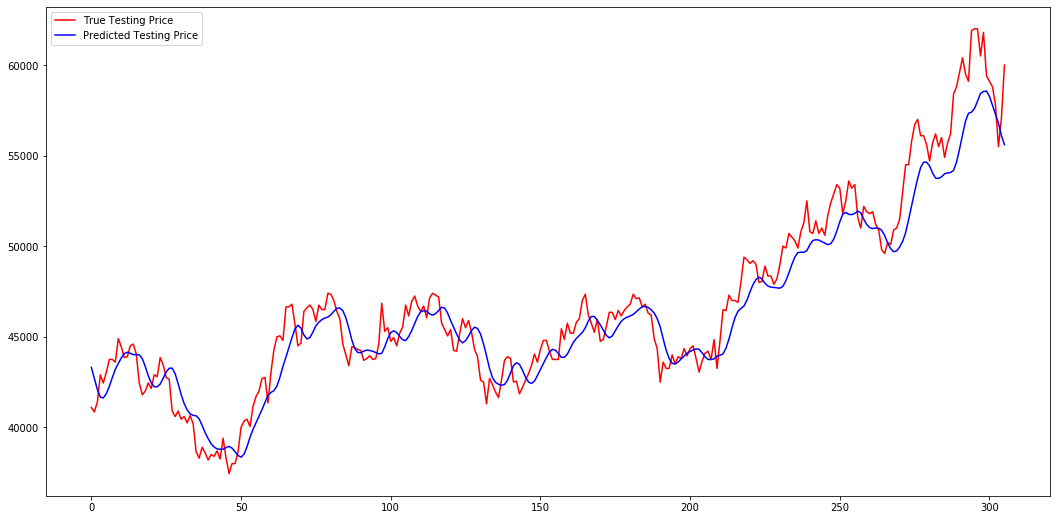

In [0]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(18,9))
ax.plot(y_test_scaled, color='red', label='True Testing Price')
plt.plot(predictions, color='blue', label='Predicted Testing Price')
plt.legend()